In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dataio.genetics import GeneticDataset, GeneticOneHot
import pandas as pd
import torch
from model.utils import decode_onehot
import matplotlib.pyplot as plt

In [4]:
TRAIN_PATH = "datasets/genetics/small_diptera_family-train.tsv"
VALIDATION_PATH = "datasets/genetics/small_diptera_family-validation.tsv"
TAXONOMY_NAME = "family"
PROTOTYPE_PATH = "saved_models/genetics/prototype_saving_test_images/epoch-1/genetic-string.csv"
WEIGHT_PATH = "saved_models/genetics/prototype_saving_test_images/10_push_weights.pth"
PROTOTYPE_COUNT = 10

In [5]:
train_dataset = GeneticDataset(TRAIN_PATH,
                              "onehot", 
                              TAXONOMY_NAME)

validation_dataset = validation_dataset = GeneticDataset(VALIDATION_PATH, 
                              "onehot",
                              TAXONOMY_NAME,
                              train_dataset.get_classes(TAXONOMY_NAME)[0])


In [6]:
prototype_df = pd.read_csv(PROTOTYPE_PATH)

In [7]:
prototype_df

,key,class_index,prototype_index,patch
0,0,0,0,ACATTGTATTTTATATTA
1,1,0,1,GGAGCATGATCAGGTATA
2,2,0,2,GTAGGAACATCATTAAGA
3,3,0,3,CCTAATTCGAGCTGAATT
4,4,0,4,GGTCATCCAGGAGCATTA
...,...,...,...,...
1235,1595,39,35,TCCTATTTTATATNNNNN
1236,1596,39,36,TTATTTNNNNNNNNNNNN
1237,1597,39,37,NNNNNNNNNNNNNNNNNN
1238,1598,39,38,NNNNNNNNNNNNNNNNNN


In [8]:
prot_strings = [["" for j in range(0,40)] for i in range(0, 40)]

for i in range(0, len(prototype_df)):
    class_index = prototype_df.iloc[i]["class_index"]
    prototype_index = prototype_df.iloc[i]["prototype_index"]
    string = prototype_df.iloc[i]["patch"]

    prot_strings[class_index][prototype_index] = string

full_strings = ["".join(string) for string in prot_strings]

In [9]:
encoder = GeneticOneHot(include_height_channel=True)
tensors = [encoder(s) if s != "" else None for s in full_strings]

In [10]:
input_tensor = validation_dataset[100]

In [11]:
print(input_tensor[0], tensors[9])

tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 0.]]]) tensor([[[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 0.]]])


In [12]:
def find_matching_dims(input_tensor, prototype_tensors, class_index):
    tensor = prototype_tensors[class_index]

    if tensor is None:
        print("No prototype tensor found for class index", class_index)
        return None
    
    if input_tensor.shape != tensor.shape:
        print("Shape mismatch for class index", class_index)
        return None
    
    output = torch.eq(input_tensor, tensor)
    # sum along the channel dimension
    output = output.sum(0)
    # integer divide by the number of channels
    output = output // 4
    return output[0]

In [13]:
find_matching_dims(input_tensor[0], tensors, 9)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
# Open the weights
weights = torch.load(WEIGHT_PATH)["weight"]

class_weights = torch.zeros(40, 40)

# Reshape the weights
weights = weights.reshape(40, 40, 40)

for i in range(40):
    for j in range(40):
        class_weights[i][j] = weights[i][i][j]

In [15]:
sorted_prototype_indices = class_weights.argsort(descending=True, dim=1)
best_prototypes = sorted_prototype_indices[:, 0:PROTOTYPE_COUNT]

In [16]:
print(input_tensor[1])
for i in range(40):
    o = find_matching_dims(input_tensor[0], tensors, i)

    if o is not None:
        t = 0

        for p in best_prototypes[i]:
            t += int(o[p*18:(p+1)*18].sum())
        
        print(i, t)

tensor(9)
0 54
No prototype tensor found for class index 1
2 64
No prototype tensor found for class index 3
4 82
No prototype tensor found for class index 5
6 77
7 61
8 48
9 96
10 63
11 93
No prototype tensor found for class index 12
13 81
14 63
15 58
16 79
17 64
18 83
19 77
20 73
21 63
22 80
23 63
No prototype tensor found for class index 24
25 75
26 87
27 67
No prototype tensor found for class index 28
29 62
30 87
31 81
32 62
No prototype tensor found for class index 33
34 67
No prototype tensor found for class index 35
No prototype tensor found for class index 36
37 95
38 87
39 82


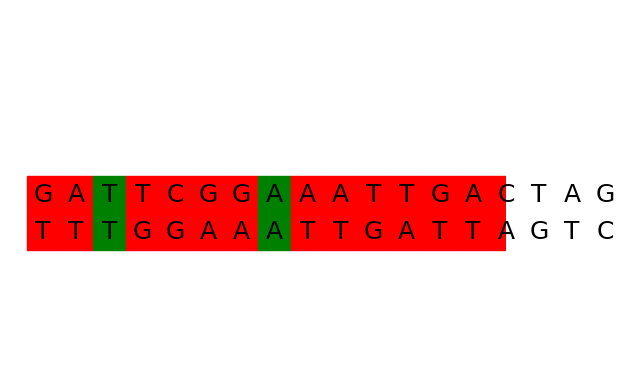

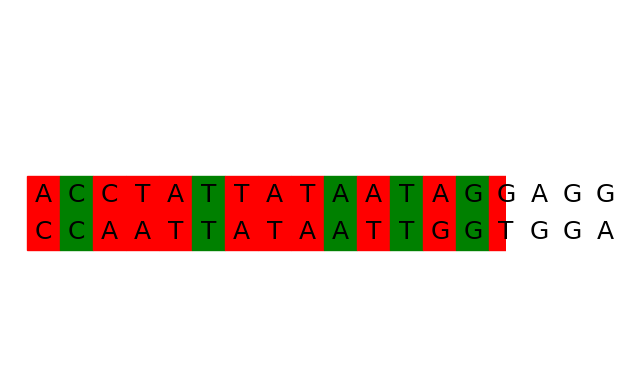

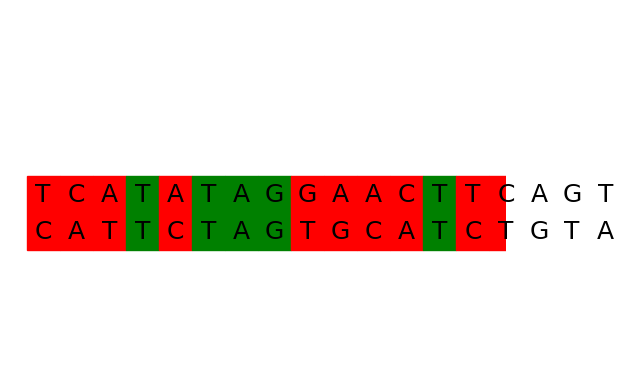

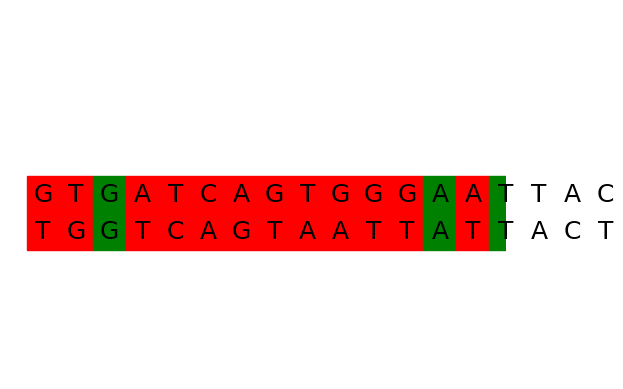

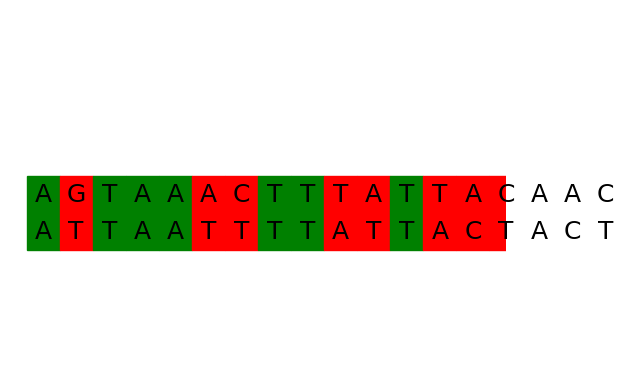

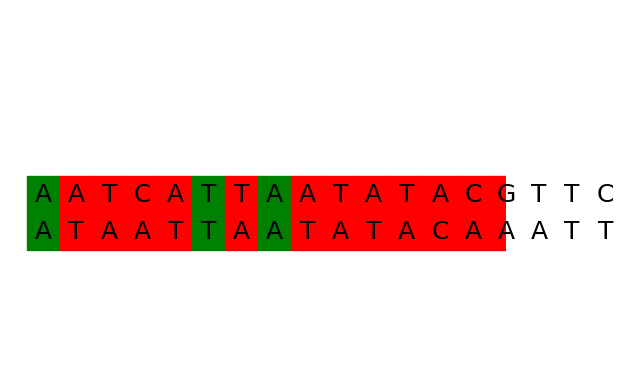

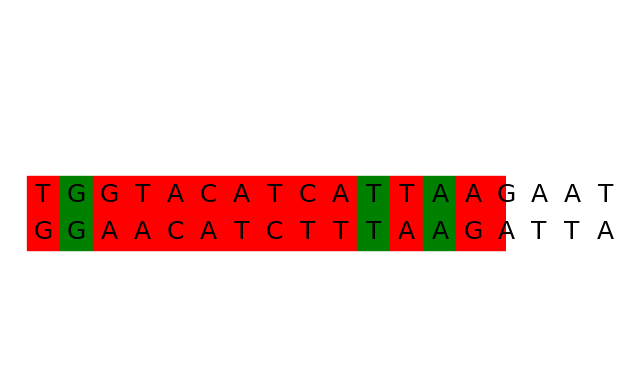

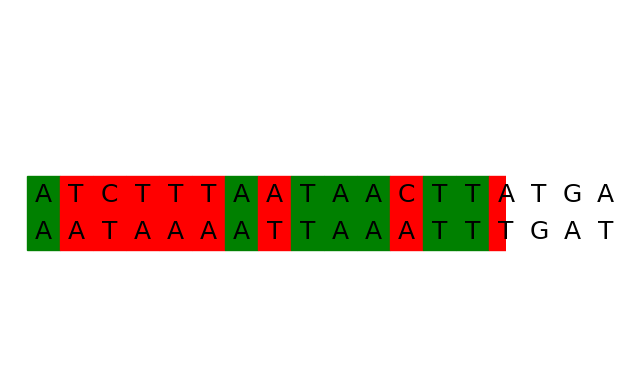

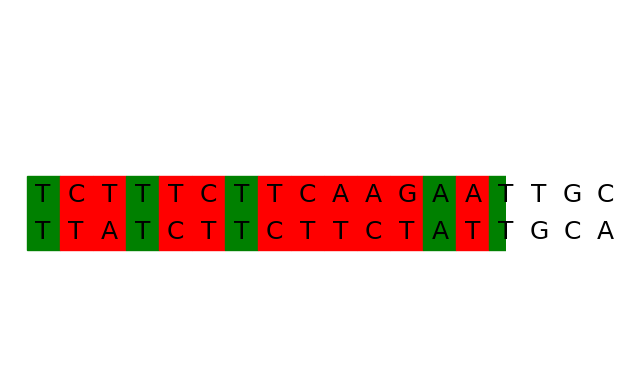

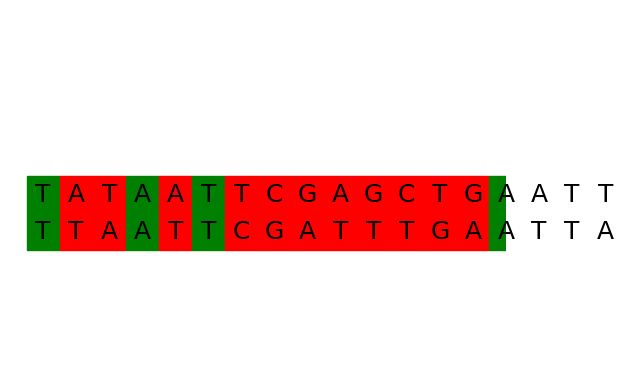

In [58]:
# 2
# 3
for i in range(PROTOTYPE_COUNT):
    string = decode_onehot(input_tensor[0].numpy(), three_dim=True)

    # print(string[best_prototypes[9][i]*18:(best_prototypes[9][i]+1)*18])
    # print("")

    # Draw 18 squares each with one character of prot using matplotlib
    prot = prot_strings[8][int(best_prototypes[8][i])]
    corresponding = string[best_prototypes[8][i]*18:(best_prototypes[8][i]+1)*18]

    for i, c in enumerate(prot):
        plt.text(.05 * i+.05, 0.5, c, fontsize=18, ha='center', va='center')
        plt.text(.05 * i+.05, 0.4, corresponding[i], fontsize=18, ha='center', va='center')
        # Color the squares based on whether the character matches the prototype
        if c == corresponding[i]:
            plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='green'))
        else:
            plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='red'))

    # Resize plot to fit the text
    plt.gca().set_xlim([0, ])

    # Hide plot axis
    plt.axis('off')
    plt.show()

In [ ]:
is_best_prototype_location = torch.zeros(40, 40*18)

for i in range(40):
    best_prototypes_for_class = best_prototypes[i]

    for ind, j in enumerate(best_prototypes_for_class):
        # is_best_prototype_location[i][j*18:(j+1)*18] = (10 - ind) / 10
        is_best_prototype_location[i][j*18:(j+1)*18] = 1

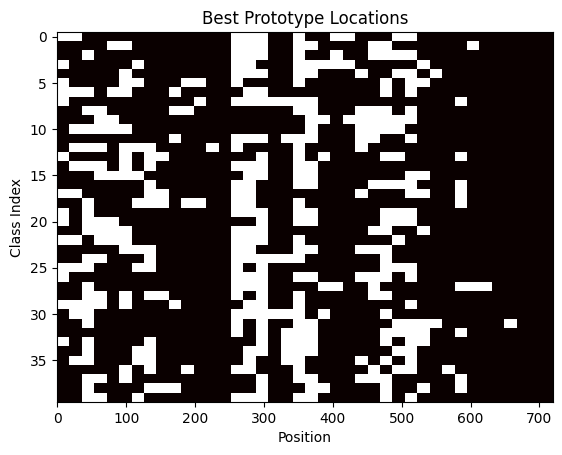

In [ ]:
# Draw the heatmap
import matplotlib.pyplot as plt

plt.imshow(is_best_prototype_location, cmap='hot', interpolation='nearest')
plt.title("Best Prototype Locations")
plt.ylabel("Class Index")
plt.xlabel("Position")

# Make its aspect ratio 1:1
plt.gca().set_aspect('auto', adjustable='box')